# 📉 Capítulo 5 – Detección de Anomalías con Análisis de Componentes Principales (PCA)

En este capítulo se explorará el uso del **Análisis de Componentes Principales (PCA)** como técnica de detección de anomalías.  
El PCA es un método estadístico que busca **reducir la dimensionalidad** de un conjunto de datos preservando la mayor cantidad posible de varianza. Para ello, transforma las variables originales en un nuevo conjunto de variables ortogonales llamadas *componentes principales*.  

El fundamento para la detección de anomalías radica en que, si los datos normales se pueden representar adecuadamente en un subespacio de baja dimensión, entonces los puntos anómalos tendrán **mayores errores de reconstrucción** o se ubicarán en regiones de baja varianza explicada.

---

## 🎯 ¿Por qué PCA?

Las razones para emplear PCA en la detección de anomalías incluyen:

- Permite **capturar la estructura subyacente** de los datos, reduciendo el ruido.
- Detecta observaciones que **no se ajustan bien** al subespacio de máxima varianza.
- Es un modelo **estadísticamente interpretable**: se pueden analizar las contribuciones de cada variable a las componentes principales.
- Se puede aplicar tanto a **datos tabulares** como a **series temporales multivariantes** (previo preprocesamiento en ventanas).

---

## 🧭 Objetivo de este capítulo

En este capítulo se abordará:

- Una introducción teórica al PCA aplicado a anomalías.
- La definición del **error de reconstrucción** como score de anomalía.
- La aplicación del PCA sobre datos sintéticos con fines explicativos.

---

## 🔍 Intuición

El PCA busca un subespacio de baja dimensión que explique la mayoría de la variabilidad de los datos.  
La idea clave es:

> "Si un punto no puede reconstruirse bien a partir de los componentes principales, es probablemente una anomalía."

Esto significa que, mientras los datos normales se alinean con las direcciones de mayor varianza, las anomalías quedan **fuera del subespacio principal** y presentan un **error de reconstrucción elevado**.

---

## 🧠 Fundamento Teórico

Sea $X \in \mathbb{R}^{n \times d}$ un conjunto de $n$ observaciones y $d$ variables:

1. Se centra la matriz restando la media.
2. Se calcula la matriz de covarianza $ \Sigma = \frac{1}{n} X^T X $.
3. Se obtienen los vectores propios (componentes) y valores propios (varianza explicada).
4. Se proyectan los datos en los $k$ primeros componentes:
   $$
   Z = X W_k
   $$
   donde $W_k$ contiene los $k$ vectores propios principales.
5. Se reconstruyen los datos:
   $$
   \hat{X} = Z W_k^T
   $$

El **error de reconstrucción** para cada observación $x_i$ es:
$$
e_i = \lVert x_i - \hat{x}_i \rVert^2
$$

---

## 📊 Interpretación del Score

- **Error bajo** → El punto se ajusta bien al subespacio → Normal.  
- **Error alto** → El punto queda fuera del subespacio → Posible anomalía.  

Un umbral típico se define como:
$$
\tau = \mu_e + 3\sigma_e
$$
donde $\mu_e$ y $\sigma_e$ son la media y desviación estándar de los errores de reconstrucción en el conjunto de entrenamiento.

---

## ⚙️ Parámetros Clave

- **n_components**: número de componentes a retener.  
  - Demasiados → el error disminuye, pero se pierde sensibilidad.  
  - Muy pocos → se pierden patrones relevantes.  
- **Threshold**: umbral de error para decidir qué es anómalo. Puede fijarse estadísticamente o mediante percentiles.  

---

## ✅ Ventajas

- Método **clásico, rápido y fácil de implementar**.
- Facilita la **interpretación estadística** de los resultados.
- Útil como **baseline** para comparar modelos más complejos.
- Puede detectar anomalías que se desvían en combinaciones de variables, no solo en valores individuales.

---

## 🚫 Limitaciones

- Es un método **lineal**: no capta relaciones no lineales entre variables.
- Sensible a la **escala de los datos** → requiere normalización previa.
- Si las anomalías se encuentran dentro del subespacio principal (es decir, son coherentes con las direcciones de mayor varianza), el PCA puede **no detectarlas**.

---

### 🔧 Ejemplo conceptual

Consideremos un sistema con dos variables: **RPM** y **temperatura del refrigerante**.

- En condiciones normales, los datos se alinean en una dirección oblicua (a mayor RPM, mayor temperatura).
- El PCA proyectará los puntos sobre esa dirección.  
- Un punto con **temperatura muy baja para RPM altas** tendrá un gran error de reconstrucción, indicando anomalía.

---

## 🔗 Referencias

- Jolliffe, Ian T., and Jorge Cadima.  
**"Principal component analysis: a review and recent developments."** *Philosophical Transactions of the Royal Society A* 374.2065 (2016): 20150202.

- Shyu, Mei-Ling, et al.  
**"A novel anomaly detection scheme based on principal component classifier."** *Proceedings of the IEEE Foundations and New Directions of Data Mining Workshop*. 2003.


## Análisis de señales sintéticas para detección de anomalías

En esta sección trabajaremos con un **dataset sintético generado específicamente para la explicación y demostración de modelos de detección de anomalías**.  

El dataset contiene **tres señales distintas pero relacionadas entre sí**, diseñadas para reflejar dinámicas variadas y al mismo tiempo mantener cierta correlación. Esto nos permite ilustrar el funcionamiento de los algoritmos en un entorno controlado y reproducible, sin depender de etiquetas externas.  

Las señales incluidas son:

- **f1**: onda sinusoidal con ruido, que aporta una dinámica periódica y suave.  
- **f2**: onda cuadrada con ruido, de cambios bruscos y alternancia marcada.  
- **f3**: un proceso aleatorio acumulado (*random walk*), que muestra un comportamiento errático y distinto de las anteriores.  

Sobre estas señales se han inyectado anomalías de manera **aleatoria en forma, intensidad, duración y señales afectadas**, lo que genera escenarios más realistas. Entre los tipos de anomalías posibles se incluyen:  

- **Picos aislados** de distinta magnitud.  
- **Derivas temporales (drift)** con pendientes y duraciones variables.  
- **Tramos planos (flat)** en valor cero o mantenidos artificialmente.  
- **Ruido anómalo** de alta intensidad en segmentos cortos.  

Este diseño permite observar cómo un mismo algoritmo puede reaccionar ante anomalías muy diferentes, lo que resulta útil para entender mejor sus fortalezas y limitaciones.  

A continuación se podrán ver las señales.

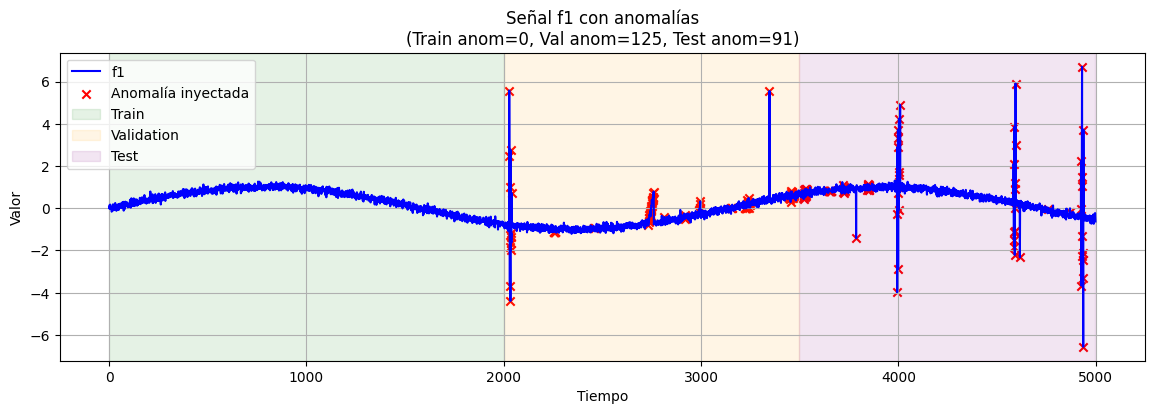

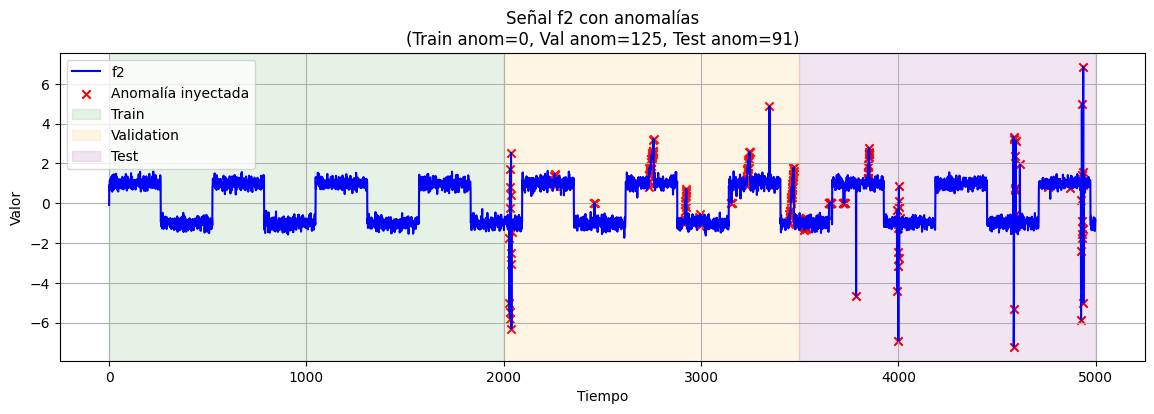

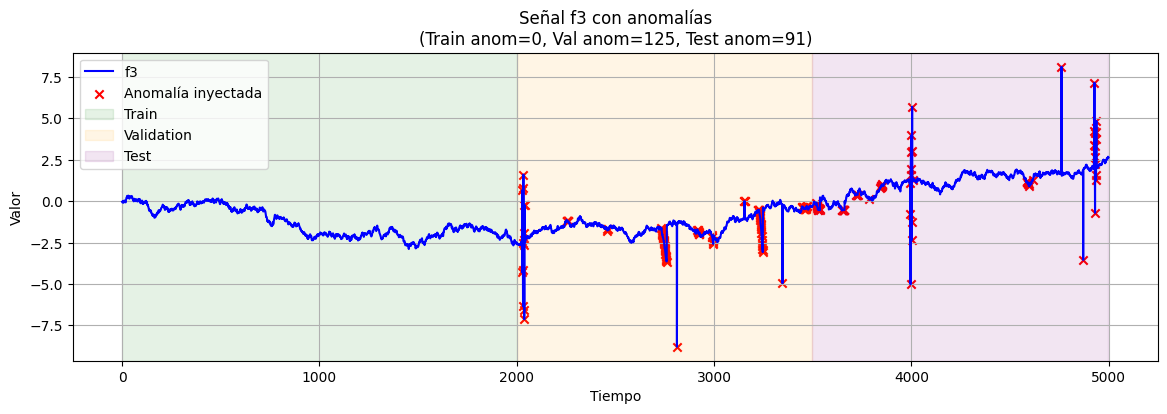

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
from utils import generate_synthetic_timeseries

train_df, val_df, test_df = generate_synthetic_timeseries(
    n=5000,
    train_ratio=0.4,
    val_ratio=0.3,
    anomaly_ratio=0.008,
    seed=42
)

# Concatenar
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Límites de los splits
train_end = train_df["timestamp"].max()
val_end = val_df["timestamp"].max()

# Visualización
for col in ["f1", "f2", "f3"]:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(full_df["timestamp"], full_df[col], label=f"{col}", color="blue")

    # Anomalías
    anomaly_idx = full_df[full_df["anomaly"] == 1].index
    ax.scatter(full_df.loc[anomaly_idx, "timestamp"],
               full_df.loc[anomaly_idx, col],
               color="red", marker="x", label="Anomalía inyectada")

    # Fondos para train / val / test
    ax.axvspan(full_df["timestamp"].min(), train_end, alpha=0.1, color="green", label="Train")
    ax.axvspan(train_end, val_end, alpha=0.1, color="orange", label="Validation")
    ax.axvspan(val_end, full_df["timestamp"].max(), alpha=0.1, color="purple", label="Test")

    ax.set_title(
        f"Señal {col} con anomalías\n"
        f"(Train anom={train_df['anomaly'].sum()}, "
        f"Val anom={val_df['anomaly'].sum()}, "
        f"Test anom={test_df['anomaly'].sum()})"
    )
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Valor")
    ax.legend()
    ax.grid(True)
    plt.show()


### Validación del modelo en el proyecto

En este proyecto, las anomalías no se consideran a nivel de **señal individual**, sino a nivel de **timestamp**:  
lo relevante es si en un instante de tiempo ocurre una anomalía, independientemente de en qué señal se manifieste.  

A continuación, se presenta un ejemplo de cómo se lleva a cabo la **validación del modelo**, siguiendo el *Pipeline de Validación* implementado.  
Este proceso nos permitirá:  

- Obtener distintas **métricas de rendimiento** sobre los datos utilizados.  
- Generar **gráficas informativas** que ayuden a evaluar la calidad de las predicciones del modelo.  


Resultados de validación PCA (grid search en train+val):


,precision,recall,f1,roc_auc,nab,window_cov,n_components,threshold
0,0.573,0.536,0.506,0.739,0.686,0.539,1,0.800
1,0.574,0.529,0.503,0.739,0.715,0.526,1,0.850
2,0.566,0.493,0.483,0.739,0.741,0.505,1,0.900
3,0.574,0.427,0.439,0.739,0.745,0.431,1,0.950
4,0.431,0.153,0.164,0.739,0.537,0.132,1,0.990
5,0.231,0.125,0.117,0.739,0.412,0.104,1,0.997
6,0.585,0.471,0.470,0.759,0.785,0.493,2,0.800
7,0.519,0.432,0.434,0.759,0.749,0.457,2,0.850
8,0.525,0.419,0.427,0.759,0.779,0.444,2,0.900
9,0.506,0.274,0.322,0.759,0.732,0.311,2,0.950


Top 5 configuraciones (ordenadas por NAB en validación):


,precision,recall,f1,roc_auc,nab,window_cov,n_components,threshold
6,0.585253,0.471285,0.470296,0.758955,0.785486,0.493103,2,0.80
8,0.525450,0.418890,0.426917,0.758955,0.779142,0.444362,2,0.90
7,0.518641,0.431980,0.433835,0.758955,0.748547,0.456812,2,0.85
3,0.574019,0.426898,0.439138,0.738590,0.744639,0.430812,1,0.95
2,0.566459,0.493429,0.483162,0.738590,0.741178,0.504701,1,0.90




Evaluación final en TEST con las 5 mejores configuraciones

Resultados para PCA con n_components=2, threshold=0.8


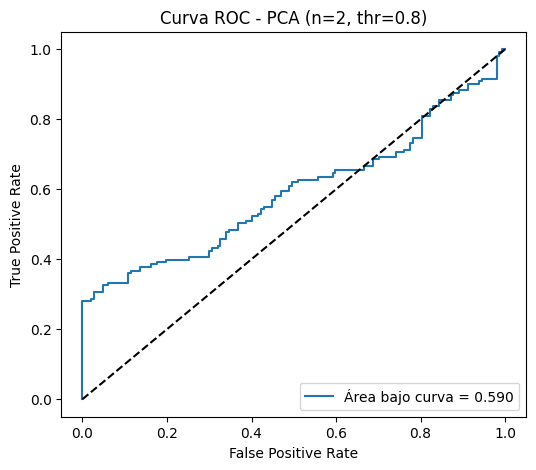

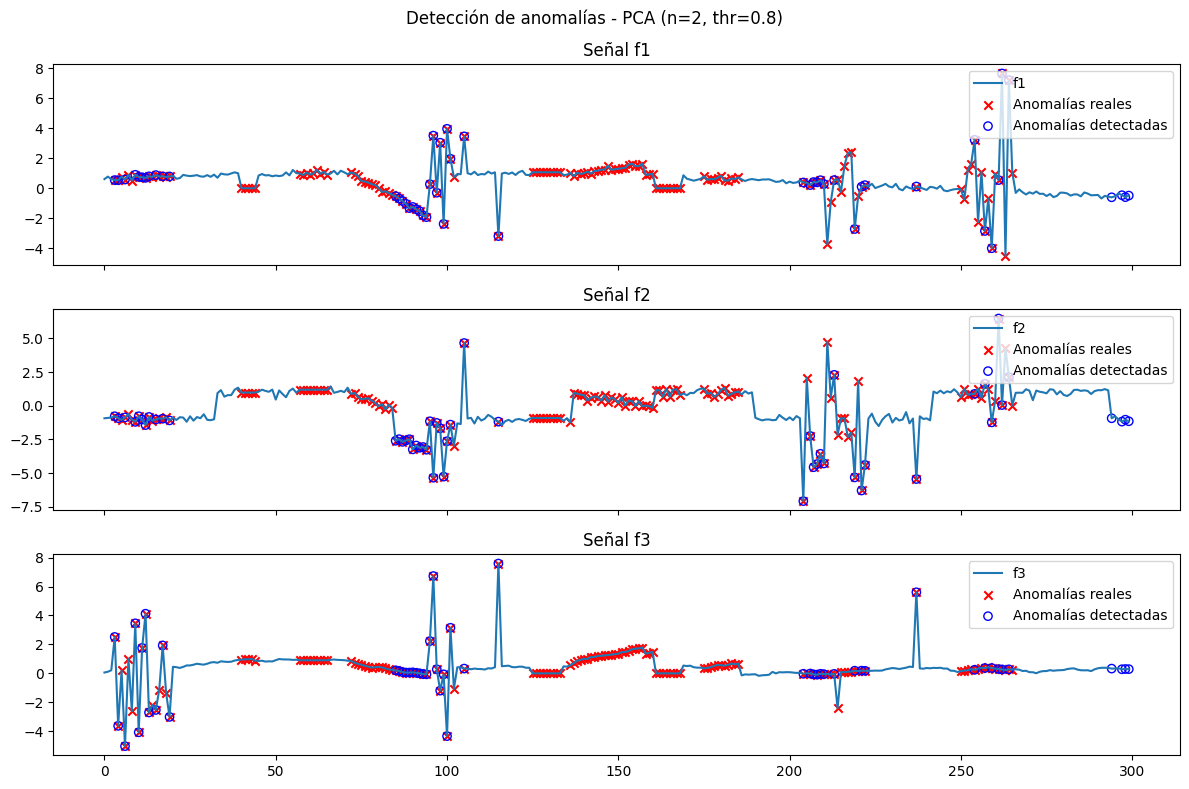


Resultados para PCA con n_components=2, threshold=0.9


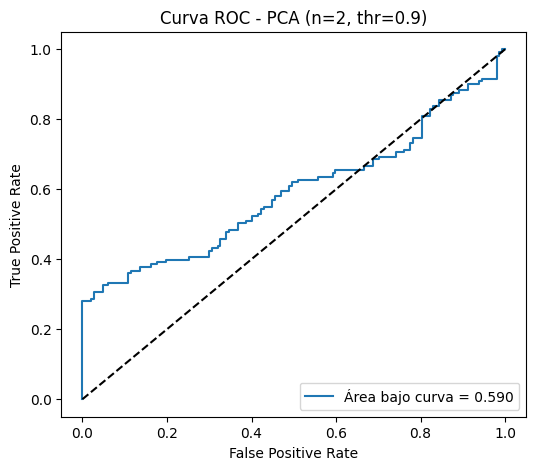

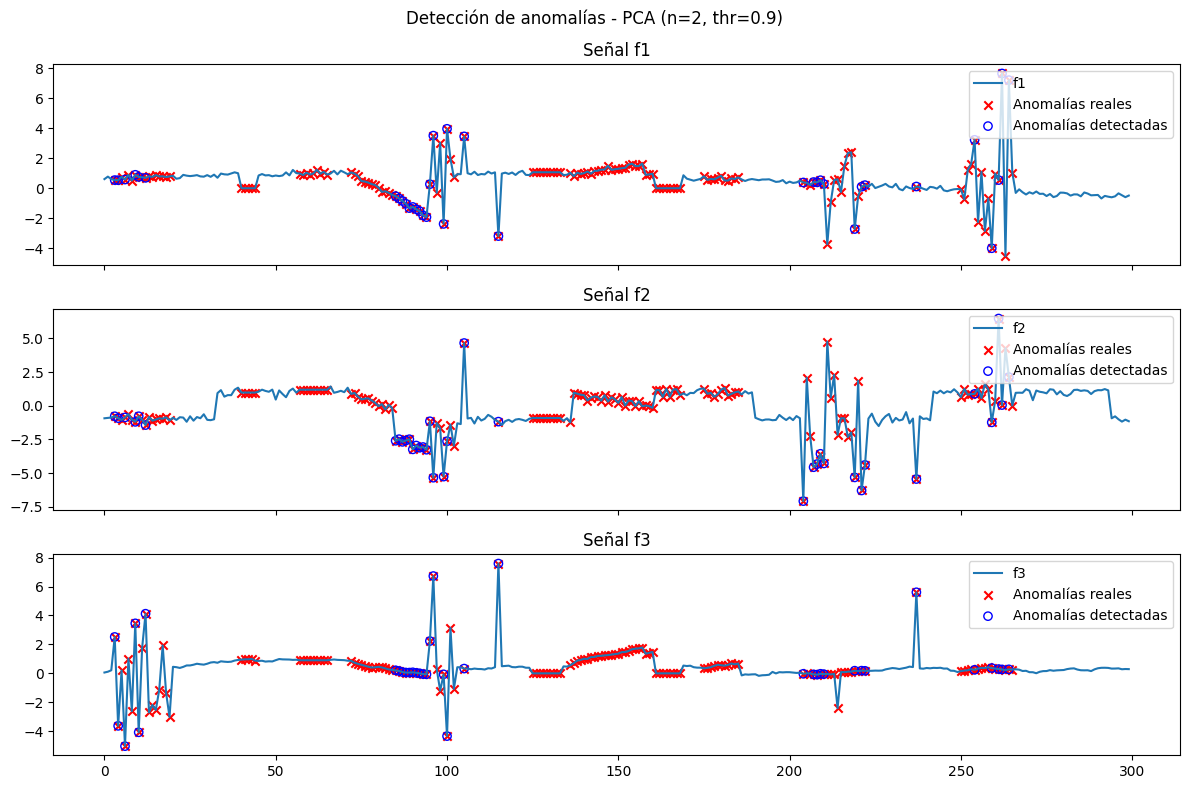


Resultados para PCA con n_components=2, threshold=0.85


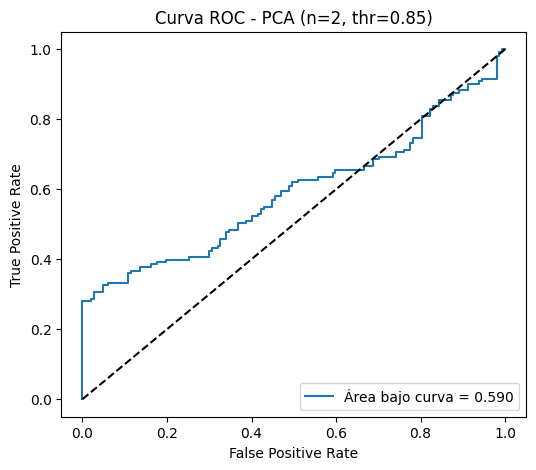

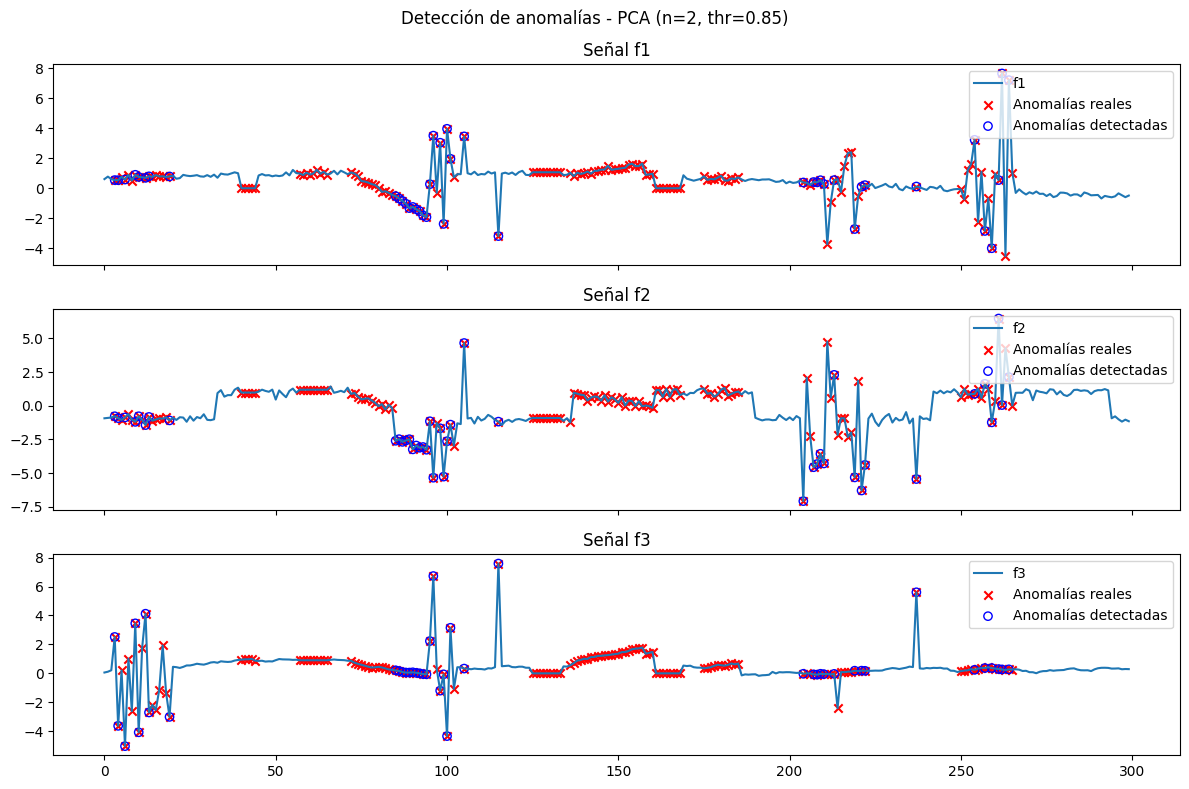


Resultados para PCA con n_components=1, threshold=0.95


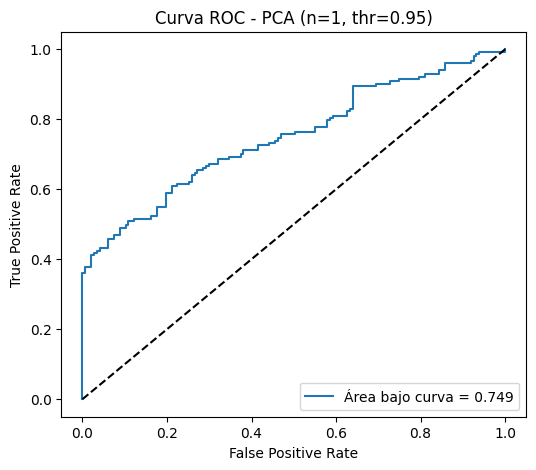

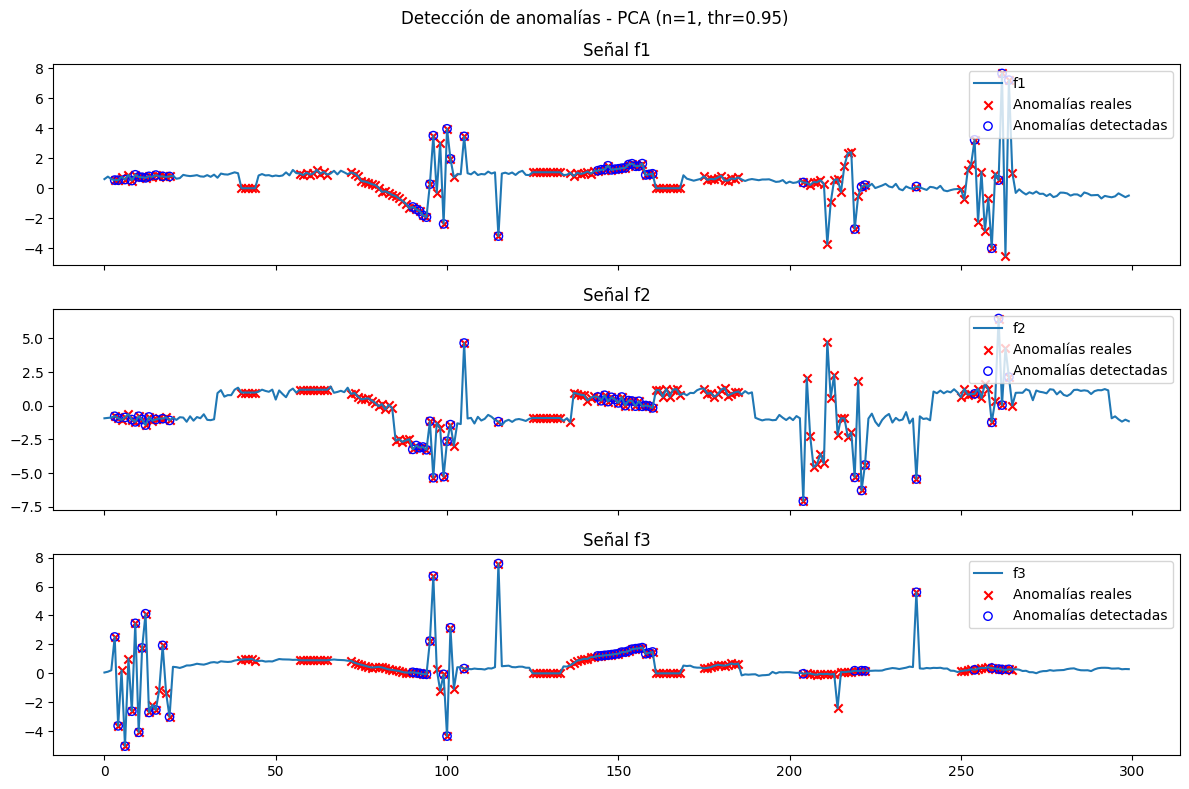


Resultados para PCA con n_components=1, threshold=0.9


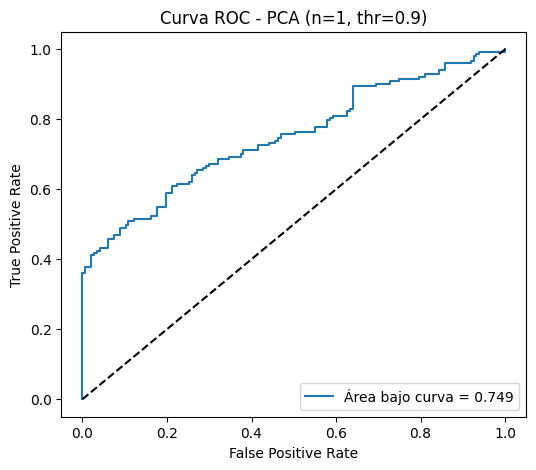

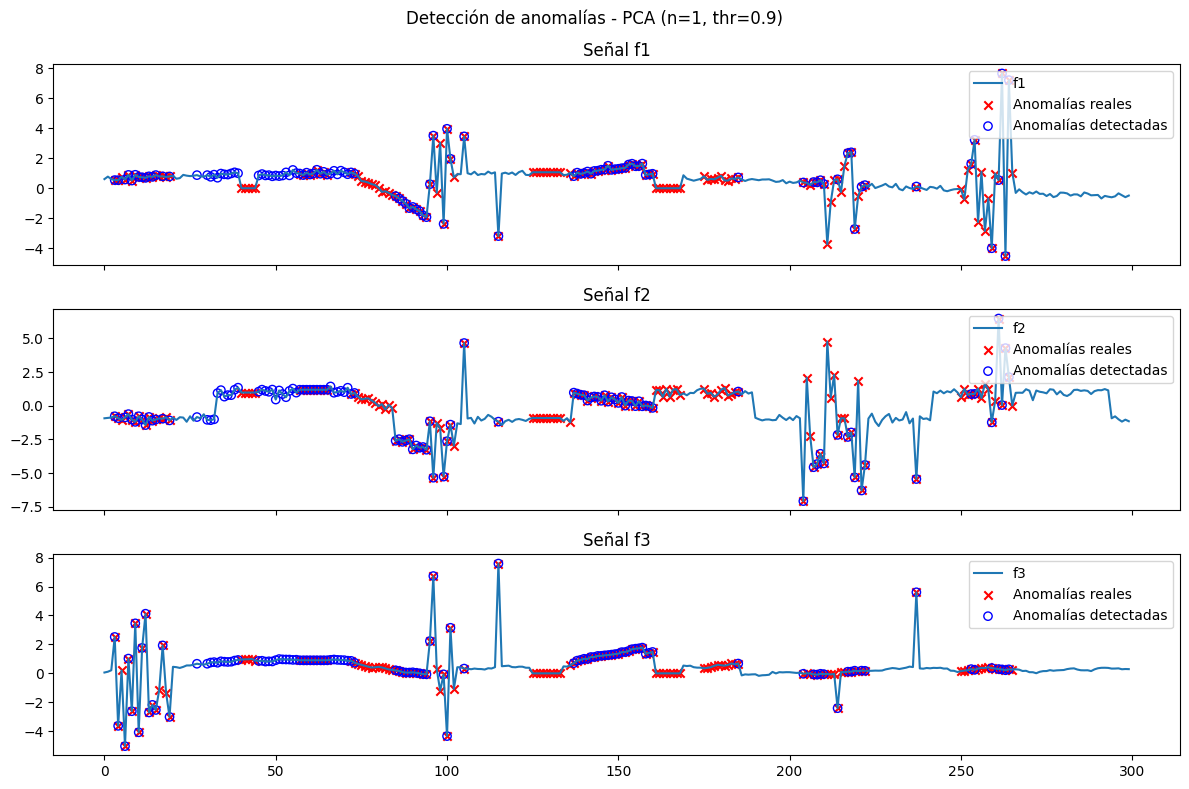



Resultados finales en TEST (top-5 configs):


,n_components,threshold,precision,recall,f1,roc_auc,nab,window_cov
0,2,0.80,0.922,0.307,0.461,0.590,0.544,0.425
1,2,0.90,1.000,0.235,0.381,0.590,0.562,0.378
2,2,0.85,1.000,0.275,0.431,0.590,0.562,0.403
3,1,0.95,1.000,0.333,0.500,0.749,0.640,0.422
4,1,0.90,0.748,0.562,0.642,0.749,0.898,0.601


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from utils import generate_synthetic_timeseries
from modelos.PCAAnomalyDetector import PCAAnomalyDetector
from modelos.validation_metrics import (
    precision_metric, recall_metric, f1_metric,
    roc_auc_metric, nab_metric, window_coverage_metric
)
from modelos.ValidationPipeline import ValidationPipeline

# ==========================
# 1. Generar datos sintéticos
# ==========================
df_train, df_val, df_test = generate_synthetic_timeseries(
    n=1000, train_ratio=0.4, val_ratio=0.3, anomaly_ratio=0.06, seed=42
)

# Usamos train + val para validación
df_trainval = pd.concat([df_train, df_val], ignore_index=True)

X_trainval = df_trainval[["f1", "f2", "f3"]]
y_trainval = df_trainval["anomaly"]

# Test reservado para evaluación final
X_test = df_test[["f1", "f2", "f3"]]
y_test = df_test["anomaly"]

# ==========================
# 2. Definir métricas
# ==========================
metrics = {
    "precision": precision_metric,
    "recall": recall_metric,
    "f1": f1_metric,
    "roc_auc": roc_auc_metric,
    "nab": nab_metric,
    "window_cov": window_coverage_metric
}

params_tscv = {"P_train": 0.4, "num_windows": 15}

# ==========================
# 3. Grid search sobre n_components y thresholds
# ==========================
grid_results = []

for n in [1, 2, 3]:                     # valores de n_components
    for thr in [0.8, 0.85, 0.90, 0.95, 0.99, 0.997]:   # percentiles
        model = PCAAnomalyDetector(n_components=n, threshold=thr)
        pipeline = ValidationPipeline(
            model=model,
            metrics=metrics,
            mode="tscv",
            params=params_tscv,
            seasonal_period="auto",
            hampel_cfg={"window": 25, "sigma": 5.0}
        )
        results = pipeline.validate(X_trainval, y_trainval)
        results["n_components"] = n
        results["threshold"] = thr
        grid_results.append(results)

df_results = pd.DataFrame(grid_results)

# ==========================
# 4. Resultados de validación
# ==========================
pd.set_option("display.width", 200)
pd.set_option("display.max_columns", None)
print("Resultados de validación PCA (grid search en train+val):")
display(df_results.round(3))  # mejor en Jupyter que con print()

# ==========================
# 5. Selección de top-5 configuraciones
# ==========================
# criterio: F1 (puedes cambiar a roc_auc, nab, etc.)
df_sorted = df_results.sort_values(by="nab", ascending=False)
top5 = df_sorted.head(5)

print("="*60)
print("Top 5 configuraciones (ordenadas por NAB en validación):")
print("="*60)
display(top5)

# ==========================
# 6. Evaluación final en test
# ==========================
print("\n")
print("="*60)
print("Evaluación final en TEST con las 5 mejores configuraciones")
print("="*60)

final_results = []

for i, row in top5.iterrows():
    n = int(row["n_components"])
    thr = float(row["threshold"])
    model = PCAAnomalyDetector(n_components=n, threshold=thr)

    print("\n" + "="*60)
    print(f"Resultados para PCA con n_components={n}, threshold={thr}")
    print("="*60)

    # Entrenamiento con train+val
    model.fit(X_trainval)

    # Predicción en test
    y_pred = model.predict(X_test)
    y_score = model.anomaly_score(X_test)

    # Métricas en test
    res = {"n_components": n, "threshold": thr}
    for name, metric in metrics.items():
        res[name] = metric(y_test.to_numpy().astype(int), y_pred, y_score)
    final_results.append(res)

    # -------------------------
    # Gráfico 1: Curva ROC
    # -------------------------
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc_val = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"Área bajo curva = {roc_auc_val:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"Curva ROC - PCA (n={n}, thr={thr})")
    plt.legend(loc="lower right")
    plt.show()

    # -------------------------
    # Gráfico 2: Anomalías en las señales
    # -------------------------
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    signals = ["f1", "f2", "f3"]

    for j, sig in enumerate(signals):
        axes[j].plot(X_test.index, X_test[sig], label=sig)
        axes[j].scatter(
            X_test.index[y_test == 1], 
            X_test[sig][y_test == 1],
            color="red", marker="x", label="Anomalías reales"
        )
        axes[j].scatter(
            X_test.index[y_pred == 1],
            X_test[sig][y_pred == 1],
            facecolors="none", edgecolors="blue", label="Anomalías detectadas"
        )
        axes[j].set_title(f"Señal {sig}")
        axes[j].legend(loc="upper right")

    plt.suptitle(f"Detección de anomalías - PCA (n={n}, thr={thr})")
    plt.tight_layout()
    plt.show()


# ==========================
# 7. Tabla resumen en test
# ==========================
df_final = pd.DataFrame(final_results)
print("\n")
print("="*60)
print("Resultados finales en TEST (top-5 configs):")
print("="*60)
display(df_final.round(3))


Este ejemplo ilustra el proceso de validación de un modelo de detección de anomalías en series temporales empleando PCA. Se trata de un enfoque muy básico, ya que por sí mismo no es capaz de capturar las dependencias temporales presentes en los datos.

Existen extensiones sencillas que permiten incorporar cierta información temporal, como el uso de diferencias primeras (deltas) o derivadas segundas, que ayudan a que el modelo sea algo más sensible a la dinámica de las señales. Sin embargo, dado que el objetivo aquí es únicamente mostrar el funcionamiento general del PCA como técnica de referencia, no profundizamos más en dichas variantes.

En los siguientes capítulos se abordarán modelos más avanzados, específicamente diseñados para tratar con la naturaleza temporal de los datos y que ofrecerán un rendimiento claramente superior en la detección de anomalías.

## 📌 Conclusiones del capítulo

En este capítulo se ha mostrado cómo el **PCA** puede emplearse como técnica sencilla y explicativa para la **detección de anomalías en series temporales multivariantes**.  

Los resultados obtenidos permiten destacar varios puntos:  


- El PCA resulta útil como **baseline**: permite ver cómo un método estadístico clásico se comporta frente a anomalías inyectadas en un entorno controlado.  
- El ajuste del umbral de decisión (threshold) no resulta tan determinante por sí solo: en los experimentos con PCA se observó que el número de componentes principales tiene un impacto igualmente relevante. De hecho, con thresholds bajos (p. ej., 0.8) y n_components=2, el modelo se comportó de manera más conservadora que configuraciones con thresholds más estrictos (p. ej., 0.95) pero con solo n_components=1.  
- Al no incorporar información temporal de manera explícita, el PCA **no capta dependencias dinámicas** de las señales, lo que limita su capacidad de generalización.  
- En conjunto, los resultados no son concluyentes en términos de rendimiento, lo que es coherente con el propósito de este capítulo: **ilustrar el funcionamiento del PCA aplicado a anomalías en un entorno sintético**, más que optimizar su desempeño.  
 

Este análisis permite comprender mejor las **fortalezas y limitaciones** del PCA y establece una **base de referencia** sobre la cual se podrán comparar modelos más avanzados en los capítulos posteriores.

👉 En el **próximo capítulo** se explorará el uso de **Isolation Forest**, un algoritmo basado en árboles de decisión especialmente diseñado para la detección de anomalías, que permitirá contrastar sus resultados con los obtenidos mediante PCA.
